### Group 19 Project Proposal

Title: Stellar Classification Data

#### **Introduction:** 

Our project leverages the Sloan Digital Sky Survey's seventeenth release (SDSS17), which includes a Stellar Classification Dataset with over 100,000 celestial observations, to distinguish between stars, galaxies, and quasars based on their spectral properties. This classification is critical because each type of celestial body has a distinct spectral signature: stars shine with a steady light, galaxies emit light from vast star collections and interstellar material, and quasars emit intense energy from supermassive black holes. By accurately classifying these entities, we gain a better understanding of the universe's structure and evolutionary processes.

**Question:** Can we predict whether a stellar object is a star, a galaxy, or a quasar based on their photometric ratios and redshifts?

Our data set comes from Kaggle and explores the classification of celestial objects into stars, galaxies, and quasars.
The variables for this dataset include observed characteristics of the object's electromagnetic radiation, its unique identifier, and identification labels of each observation.

We will select our predictor variables based on relevant research. Previous reputable celestial object catalogues classify these celestial objects into stars, galaxies, and quasars based on **multi-colour classification** and **photometric redshifts** (Wolf et al., 2017). Further evidence is given by the successful Support Vector Machine (SVM) model by Elting et al. (2018), which achieved a classification error of 3.8% based on the colour indices (u-g, g-r, r-i, and i-z) of the objects.

Color indices are the differences between the magnitudes of the object in two different filters, representing the object's color. They help to reveal the temperature and other physical properties of celestial objects (Elting et al., 2018). The redshift value is based on the increase in radiation wavelength and points to an object's lifetime and motion.

**References:** 

fedesoriano. (2022). Stellar Classification Dataset - SDSS17. Kaggle.com. https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17/data

Wolf, C., Meisenheimer, K., Kleinheinrich, M., Borch, A., Dye, S., Gray, M., Wisotzki, L., Bell, E., Rix, H., Cimatti, A., Hasinger, G., & Szokoly, G. (2004). A catalogue of the Chandra Deep Field South with multi-colour classification and photometric redshifts from COMBO-17. Astronomy and Astrophysics, 421, 913-936. https://doi.org/10.1051/0004-6361:20040525.

Elting, C., C. Bailer-Jones, & Smith, K. (2018). Photometric Classification of Stars, Galaxies and Quasars in the Sloan Digital Sky Survey DR6 Using Support Vector Machines. https://www.semanticscholar.org/paper/Photometric-Classification-of-Stars%2C-Galaxies-and-Elting-Bailer-Jones/7e880193b3a75c789c7352dd65743666af8e4dab

#### **Preliminary exploratory data analysis** 

We first install and load the necessary packages for explanatory analysis.

In [30]:
library(rvest)
library(tidyverse)
library(tidymodels)
library(tidyr)
library(dplyr)
library(ggplot2)

We read in our dataset from Kaggle:

In [31]:
URL <- 'https://raw.githubusercontent.com/jasukej/dsci-100-2024w2-group-19/main/data/star_classification.csv'
raw_data <- read_csv(URL)
glimpse(raw_data)

Rows: 100000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): class
dbl (17): obj_ID, alpha, delta, u, g, r, i, z, run_ID, rerun_ID, cam_col, fi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 100,000
Columns: 18
$ obj_ID      <dbl> 1.237661e+18, 1.237665e+18, 1.237661e+18, 1.237663e+18, 1.…
$ alpha       <dbl> 135.689107, 144.826101, 142.188790, 338.741038, 345.282593…
$ delta       <dbl> 32.4946318, 31.2741849, 35.5824442, -0.4028276, 21.1838656…
$ u           <dbl> 23.87882, 24.77759, 25.26307, 22.13682, 19.43718, 23.48827…
$ g           <dbl> 22.27530, 22.83188, 22.66389, 23.77656, 17.58028, 23.33776…
$ r           <dbl> 20.39501, 22.58444, 20.60976, 21.61162, 16.49747, 21.32195…
$ i           <dbl> 19.16573, 21.16812, 19.34857, 20.50454, 15.97711, 20.25615…
$ z           <dbl> 18.79371, 21.61427, 18.94827, 19.25010, 15.54461, 19.54544…
$ run_ID      <dbl> 3606, 4518, 3606, 4192, 8102, 8102, 7773, 7773, 3716, 5934…
$ rerun_ID    <dbl> 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301…
$ cam_col     <dbl> 2, 5, 2, 3, 3, 3, 2, 2, 5, 4, 3, 4, 2, 2, 3, 4, 5, 5, 5, 5…
$ field_ID    <dbl> 79, 119, 120, 214, 137, 110, 462, 346, 108, 122, 27, 112, …
$ spec_obj_ID 

In [32]:
# Counting number of NA values
null_counts <- raw_data |>
               summarise(across(everything(), ~sum(is.na(.)))) |>
               pivot_longer(obj_ID:fiber_ID, names_to = "variable", values_to = "NA counts")
null_counts

variable    NA counts
1  obj_ID      0        
2  alpha       0        
3  delta       0        
4  u           0        
5  g           0        
6  r           0        
7  i           0        
8  z           0        
9  run_ID      0        
10 rerun_ID    0        
11 cam_col     0        
12 field_ID    0        
13 spec_obj_ID 0        
14 class       0        
15 redshift    0        
16 plate       0        
17 MJD         0        
18 fiber_ID    0

The dataset is tidy and contains no null values. We first remove all duplicate observations with the same spec_obj_ID, as they refer to the same optical spectroscopic object (hence they have the same class). We will mutate the data to display color indices in order of the electromagnetic radiation spectrum instead of the photometric values alone. To fit the data with our analysis, we establish the 'class' as a categorical variable, and select only the relevant variables to our classification problem:
* u-z, g-r, r-i, i-z color indices
* redshift values

In [34]:
# Select relevany variables and mutate for color indices
celestial <- raw_data |>
                    distinct(spec_obj_ID, .keep_all = TRUE) |>
                    mutate(u_g = u - g,     # Ultraviolet - Green
                           g_r = g - r,     # Green - Red
                           r_i = r - i,     # Red - Near Infrared
                           i_z = i - z)  |> # Near Infrared - Infrared 
                    select(class, u_g, g_r, r_i, i_z, redshift) |>
                    mutate(class = as_factor(class))
                    
head(celestial)

class  u_g      g_r     r_i     i_z      redshift 
1 GALAXY  1.60352 1.88029 1.22928  0.37202 0.6347936
2 GALAXY  1.94571 0.24744 1.41632 -0.44615 0.7791360
3 GALAXY  2.59918 2.05413 1.26119  0.40030 0.6441945
4 GALAXY -1.63974 2.16494 1.10708  1.25444 0.9323456
5 GALAXY  1.85690 1.08281 0.52036  0.43250 0.1161227
6 QSO     0.15051 2.01581 1.06580  0.71071 1.4246590

Let's now split the data for training and testing.

In [35]:
data_split <- initial_split(celestial, prop = 0.75, strata = class)
training_data <- training(data_split)
testing_data <- testing(data_split)

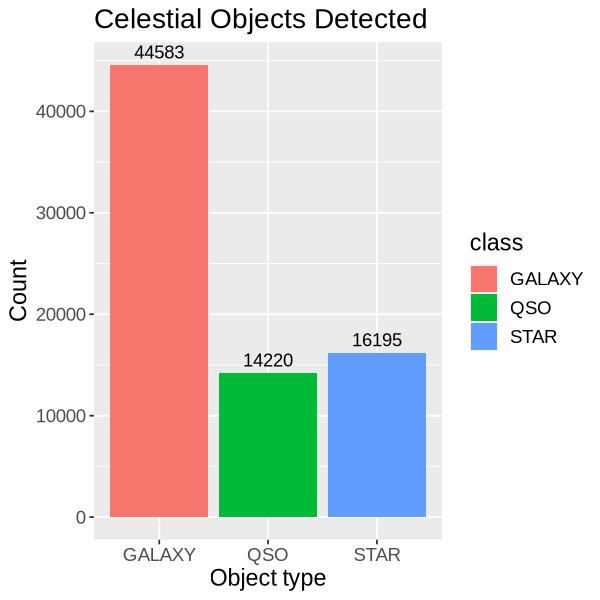

In [36]:
# Finding distribution of classes
options(repr.plot.height = 5, repr.plot.width = 5)
training_count <- training_data |> group_by(class) |> summarize(count = n()) 

training_count_plot <- training_count |> 
                        ggplot(aes(x = class, y = count, fill = class)) + 
                        geom_bar(stat = "identity") + 
                        geom_text(aes(label = count), vjust = -0.5, position = position_dodge(width = 0.9)) +
                        labs(x = "Object type", y = "Count") +
                        ggtitle("Celestial Objects Detected") + 
                        theme(text = element_text(size = 14))
training_count_plot

From this plot, we see that our training data is uneven and must be upscaled when training our algorithm. Next, we compute the summary statistics for our predictors:

In [51]:
# Table for Maximum Values
max_table <- training_data |>
    group_by(class) |>
    summarize(across(c(u_g, g_r, r_i, i_z, redshift), 
                   ~ max(., na.rm = TRUE), 
                   .names = "max_{.col}"))

# Table for Minimum Values
min_table <- training_data |>
    group_by(class) |>
    summarize(across(c(u_g, g_r, r_i, i_z, redshift), 
                   ~ min(., na.rm = TRUE), 
                   .names = "min_{.col}"))

# Table for Median Values
mean_table <- training_data |>
    group_by(class) |>
    summarize(across(c(u_g, g_r, r_i, i_z, redshift), 
                   ~ mean(., na.rm = TRUE), 
                   .names = "mean_{.col}"))

max_table
min_table
mean_table

class  max_u_g  max_g_r  max_r_i  max_i_z     max_redshift
1 GALAXY  9.65631 14.31517 10.73043     8.21675 1.995524000 
2 QSO    18.62495 11.59172  5.98677    12.54655 7.011245000 
3 STAR   10.84756  9.99114 12.20580 10017.01675 0.004153254

class  min_u_g   min_g_r      min_r_i   min_i_z   min_redshift 
1 GALAXY -12.74814    -12.31861 -12.37881 -13.16249 -0.0073516530
2 QSO     -4.56759     -4.61545 -14.64907  -6.57281  0.0004606231
3 STAR    -6.51239 -10017.16560  -7.68356  -9.88579 -0.0041360780

class  mean_u_g  mean_g_r   mean_r_i  mean_i_z  mean_redshift
1 GALAXY 1.6778651 1.31981420 0.7354847 0.4022943  0.4213244287
2 QSO    0.6211258 0.30189310 0.1924984 0.1617317  1.7227775028
3 STAR   1.5401058 0.05440479 0.4022711 0.8246255 -0.0001149786

There are clear outliers in our data that will add noise to the distribution. We will remove these outliers according to the interquartile rule. To validate our selection of predictor variables, we plot the distribution of the predictor values corresponding to each class:

In [37]:
# Pivot to display predictors beside class
predictor_distribution <- pivot_longer(training_data, -class, names_to = "predictor", values_to = "value")

# Remove outliers using the IQR rule
# Function to remove outliers
remove_outliers <- function(x) {
    q25 <- quantile(x, 0.25, na.rm = TRUE)
    q75 <- quantile(x, 0.75, na.rm = TRUE)
    iqr <- q75 - q25
    lower_bound <- q25 - 1.5 * iqr
    upper_bound <- q75 + 1.5 * iqr
    x[x < lower_bound | x > upper_bound] <- NA  # Set outliers to NA
    return(x)
}

# Apply the function to every predictor (numeric column) except 'class'
predictor_distribution_clean <- predictor_distribution |>
                                group_by(predictor) |>
                                mutate(value = remove_outliers(value))

Warning message:
“Removed 14119 rows containing non-finite values (`stat_boxplot()`).”


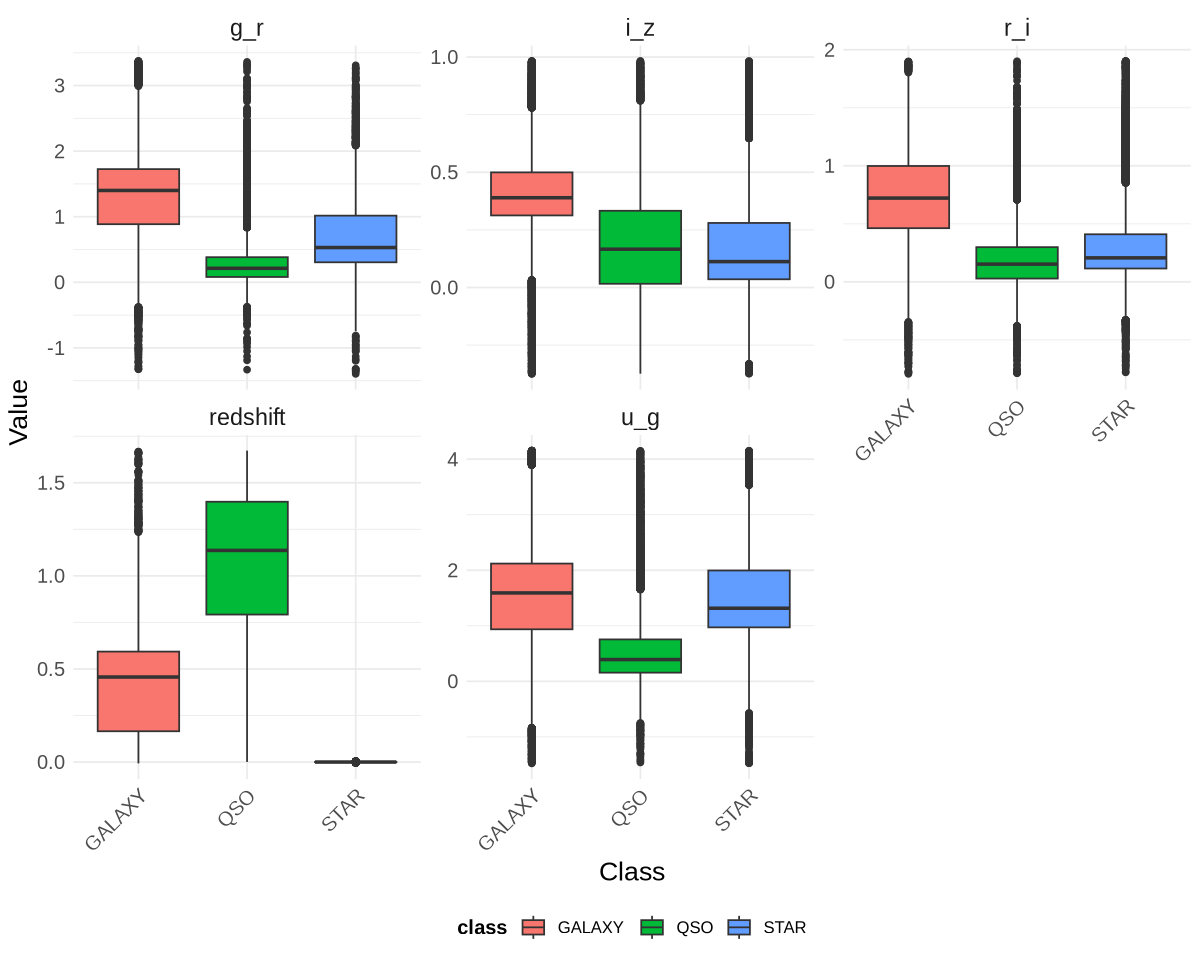

In [52]:
options(repr.plot.width = 10, repr.plot.height = 8)

# Plotting each distribution
ggplot(predictor_distribution_clean, aes(x = class, y = value, fill = class)) + 
    geom_boxplot() +  
    facet_wrap(~ predictor, scales = "free_y") +  # Each predictor is its own plot
    labs(y = "Value", x = "Class") + 
    theme_minimal() +
    theme(plot.title = element_text(size = 18, face = "bold"),
          axis.title = element_text(size = 16),
          axis.text = element_text(size = 12), 
          axis.text.x = element_text(angle = 45, hjust = 1, size = 12),
          strip.text = element_text(size = 14),
          legend.title = element_text(size = 12, face = "bold"),
          legend.text = element_text(size = 10),
          legend.position = "bottom")

Despite some overlap in the color indices, the distribution of predictor values for each class is generally distinct when compounded with the redshift values. 

#### **Methods**

We will be conducting our analysis by creating the **K-nearest neighbors** classification algorithm. We will use the variables **u_g**, **g_r**, **r_i**, **i_z**, and **redshift** as predictor variables, and **class** as the response variable. Our aim is to predict a celestial object's based on their color ratios and photometric redshifts.

We will visualize our results using a **confusion matrix**, which displays the number of correct and incorrect predictions across different classes (e.g., Galaxy, Star, Quasar). By representing the results as a matrix, we can easily identify where the model performs well and where it makes errors.

#### **Expected outcomes and Significance:**

We expect to find that objects with higher redshift values to be quasars, and lower redshift values to be galaxies, while stars have very little redshift. We expect to accurately classify the celestial objects based on combinations of their color indices and redshift values. 

The significance of our expected outcomes can streamline the classification of celestial objects, for which data is continuously updated on a large scale. Our analysis could lead to future questions such as "_Can we identify new subclasses of galaxies, stars, or quasars based on subtle variations in their color indices and redshifts?_"